# Introduction 
This project serves as a re-introduction to data science and machine learning for me. I want to go back to the fundamentals, understanding why each move is made and how it impacts the project overall.

## Dataset

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
df = pd.read_csv("predictive_maintenance.csv")

# EDA

In [3]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


#### Quick Observations on the data
- There is an identification number (UDI) that is unneccessary
- The Product ID column is also unnecessary for any analysis carried out as it is a unique identifier.
- This dataset has multiple target columns. Target and Failure Type. 

In [4]:
# Drop ID columns

df.drop(columns=['UDI','Product ID'], inplace=True)



In [5]:
df.rename(columns={'Type':'type', 'Air temperature [K]' :'air_temperature', 'Process temperature [K]':'process_temperature',
       'Rotational speed [rpm]':'rotational_speed', 'Torque [Nm]': 'torque', 'Tool wear [min]': 'tool_wear', 'Target': 'target',
       'Failure Type': 'failure_type'}, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   type                 10000 non-null  object 
 1   air_temperature      10000 non-null  float64
 2   process_temperature  10000 non-null  float64
 3   rotational_speed     10000 non-null  int64  
 4   torque               10000 non-null  float64
 5   tool_wear            10000 non-null  int64  
 6   target               10000 non-null  int64  
 7   failure_type         10000 non-null  object 
dtypes: float64(3), int64(3), object(2)
memory usage: 625.1+ KB


In [7]:
df['tool_wear'] = df['tool_wear'].astype('float64')
df['rotational_speed'] = df['rotational_speed'].astype('float64')

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
air_temperature,10000.0,300.00493,2.000259,295.3,298.3,300.1,301.5,304.5
process_temperature,10000.0,310.00556,1.483734,305.7,308.8,310.1,311.1,313.8
rotational_speed,10000.0,1538.77610,179.284096,1168.0,1423.0,1503.0,1612.0,2886.0
torque,10000.0,39.98691,9.968934,3.8,33.2,40.1,46.8,76.6
tool_wear,10000.0,107.95100,63.654147,0.0,53.0,108.0,162.0,253.0
target,10000.0,0.03390,0.180981,0.0,0.0,0.0,0.0,1.0


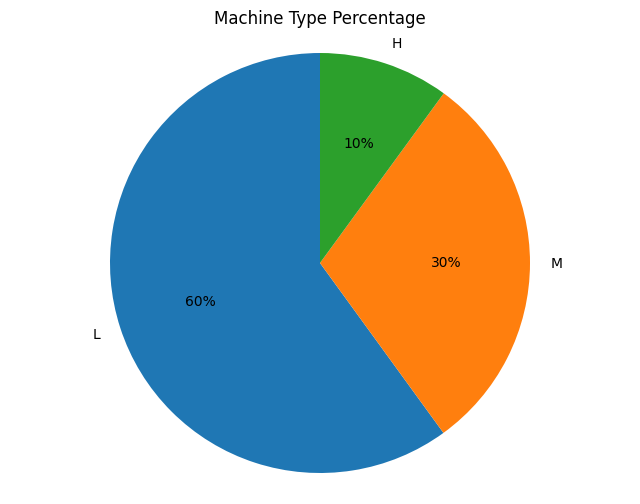

In [9]:
# Calculate the percentage of each type
type_counts = df['type'].value_counts()
type_percentage = 100 * type_counts / df['type'].shape[0]

# Prepare labels and values for the pie chart
labels = type_percentage.index
sizes = type_percentage.values

# Create a pie chart
plt.figure(figsize=(8, 6))  # Optional: Set figure size for better readability
plt.pie(sizes, labels=labels, colors=sns.color_palette('tab10')[:len(labels)], autopct='%.0f%%', startangle=90)
plt.title('Machine Type Percentage')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.

# Show the pie chart
plt.show()

This is a good enough split that does not indicate too much of oversampling. 

### Data Anomalies

Prior knowledge of this dataset confirms there are anomalies such as: 
- Values are classified as failure in the 'Target' variable but as No Failure in the 'failure_type' column.
- Values are classifed as Random Failures by 'Failure Type', but they are classifed as No failure by the 'Target Variable'

We have to eliminate them

In [10]:
df['failure_type'].value_counts()

failure_type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64

In [11]:
df_failure = df[df['target'] == 1]
df_failure['failure_type'].value_counts()

failure_type
Heat Dissipation Failure    112
Power Failure                95
Overstrain Failure           78
Tool Wear Failure            45
No Failure                    9
Name: count, dtype: int64

This confirms the first anomaly and those values will be dropped. 

In [12]:
# Identify indices of rows with 'No Failure'
position_wrong_failures = df_failure[df_failure['failure_type'] == 'No Failure'].index

# Drop these indices from the original DataFrame
df.drop(position_wrong_failures, axis=0, inplace=True)

In [13]:
df_failure = df[df['target'] == 0]
df_failure['failure_type'].value_counts()

failure_type
No Failure         9643
Random Failures      18
Name: count, dtype: int64

In [14]:
#get the position of these random failures
position_wrong_random_failures = df_failure[df_failure['failure_type'] == 'Random Failures'].index

#drop the columns
df.drop(position_wrong_random_failures, axis=0, inplace=True)

In [15]:
df.reset_index(inplace=True, drop=True)

27 data points out of 10000 will be fine. 0.27%

### Outlier Inspection

In [16]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
air_temperature,9973.0,300.003259,2.000548,295.3,298.3,300.1,301.5,304.5
process_temperature,9973.0,310.004031,1.483692,305.7,308.8,310.1,311.1,313.8
rotational_speed,9973.0,1538.893212,179.412171,1168.0,1423.0,1503.0,1612.0,2886.0
torque,9973.0,39.978993,9.966805,3.8,33.2,40.1,46.7,76.6
tool_wear,9973.0,107.921087,63.649152,0.0,53.0,108.0,162.0,253.0
target,9973.0,0.033089,0.178879,0.0,0.0,0.0,0.0,1.0


The max of `rotational_speed`, `torque` and `tool_wear` being significantly different from could indicate outliers

/var/folders/bq/m6w531zj0x1d5w35rqn1s5fh0000gn/T/ipykernel_40757/1646715148.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=i, ax=axes[1, j], palette=['#976EBD'])
/var/folders/bq/m6w531zj0x1d5w35rqn1s5fh0000gn/T/ipykernel_40757/1646715148.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=i, ax=axes[1, j], palette=['#976EBD'])
/var/folders/bq/m6w531zj0x1d5w35rqn1s5fh0000gn/T/ipykernel_40757/1646715148.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=i, ax=axes[1, j], palette=['#976EBD'])
/var/folde

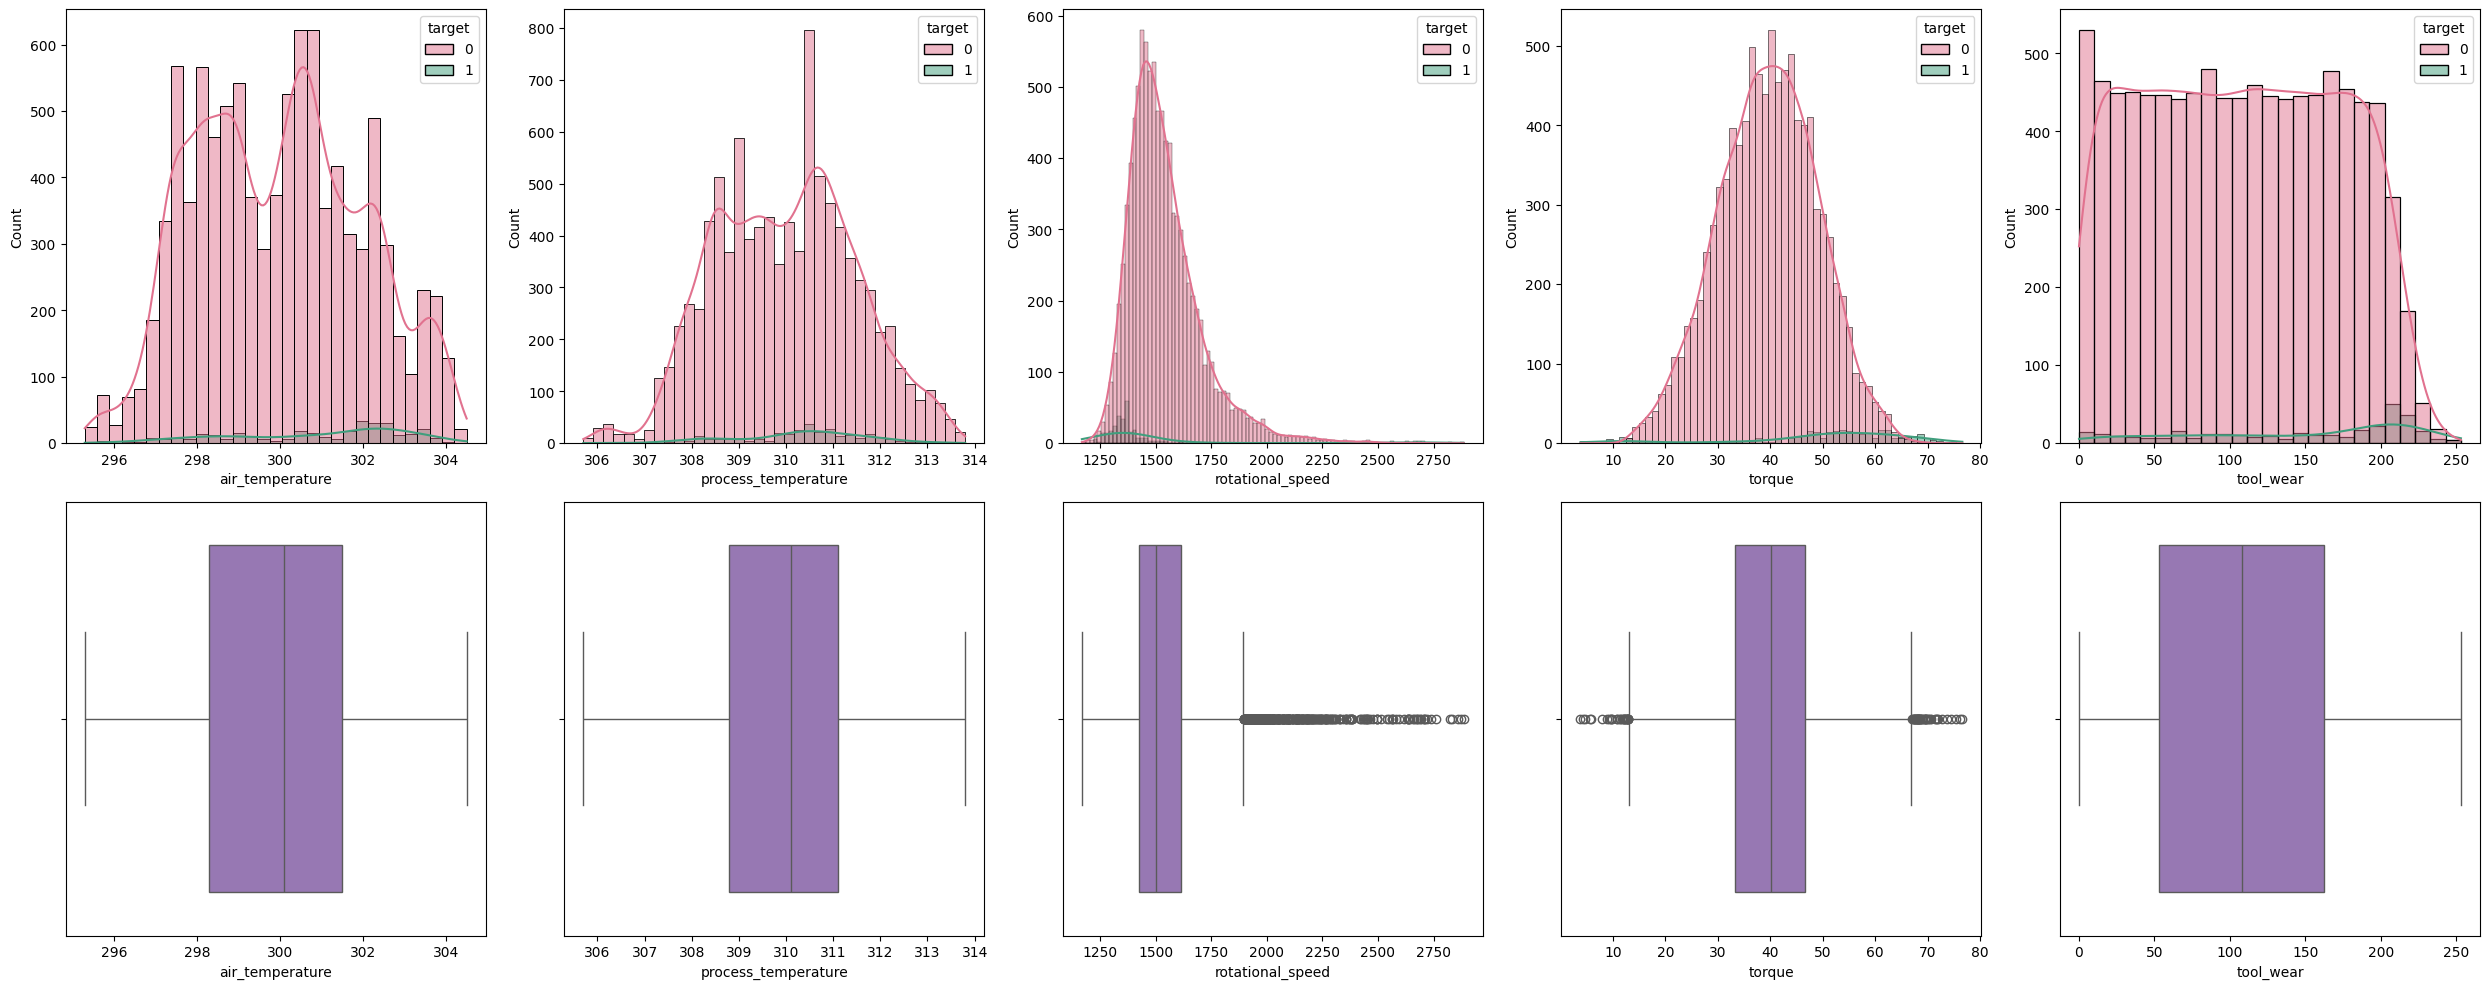

In [17]:
# Create a figure with subplots
fig, axes = plt.subplots(2, 5, figsize=[25, 10])
j = 0
colors = ['#E1728F', '#409E7D']

# List of features to plot
features = ['air_temperature', 'process_temperature', 'rotational_speed', 'torque', 'tool_wear']

for i in features:
    # Histogram with KDE
    sns.histplot(data=df, x=i, kde=True, ax=axes[0, j], hue='target', palette=colors)
    
    # Boxplot
    sns.boxplot(data=df, x=i, ax=axes[1, j], palette=['#976EBD'])
    
    j += 1

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

There are obviously outliers in the data to be dealt with later

## Preprocessing

### Data Augmentation

There were class balances as we could see which is a huge problem in machine learning problems. Some ways of solving class imbalances involve: 

- Under-sampling by deleting some data points from the majority class.
- Over-Sampling by copying rows of data resulting in the minority class.
- Over-Sampling with SMOTE (Synthetic Minority Oversampling Technique).

Failures percentage in data: 3.31
Percentage of no failure in data: 96.69


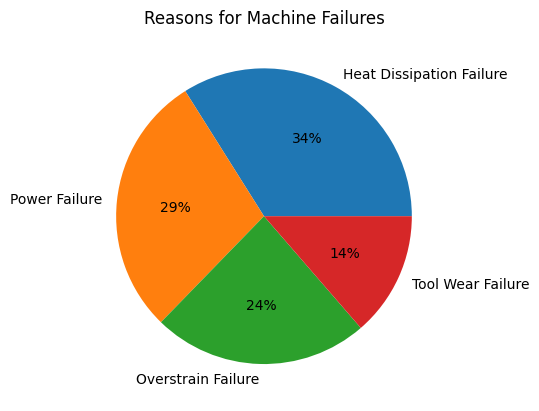

In [18]:
df_fail = df[df['failure_type'] != 'No Failure']

# Calculate failure type percentages
failure_counts = df_fail['failure_type'].value_counts()
df_fail_percentage = 100 * failure_counts / failure_counts.sum()

# Calculate overall failure percentage in the data
total_failures = df['target'].sum()
total_records = len(df)
overall_failure_percentage = round(100 * total_failures / total_records, 2)

# Print overall failure percentage
print('Failures percentage in data:', overall_failure_percentage)
print('Percentage of no failure in data:', 100 - overall_failure_percentage)

# Create a pie plot for failure causes
plt.title('Reasons for Machine Failures')
plt.pie(
    x=df_fail_percentage,
    labels=df_fail_percentage.index,
    colors=sns.color_palette('tab10')[0:4],
    autopct='%.0f%%'
)
plt.show()

96% of the data is a huge imbalance and we work to correct using SMOTE analysis. A link to an article written on the reasoning behind using that form of data augmentation will be included here.

In [19]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC

# Determine the number of 'No Failure' instances, which should represent 80% of the desired length
number_no_failure = df['failure_type'].value_counts()['No Failure']
desired_length = round(number_no_failure / 0.8)

# Calculate the number of samples needed for each failure type
samples_per_class = round((desired_length - number_no_failure) / 4)  # Distributing among four failure types

# Define the resampling strategy
resampling_strategy = {
    'No Failure': number_no_failure,
    'Overstrain Failure': samples_per_class,
    'Heat Dissipation Failure': samples_per_class,
    'Power Failure': samples_per_class,
    'Tool Wear Failure': samples_per_class
}

# Initialize the SMOTENC instance for categorical features
smote = SMOTENC(categorical_features=[0, 7], sampling_strategy=resampling_strategy, random_state=0)

# Resample the DataFrame
df_resampled, y_resampled = smote.fit_resample(df, df['failure_type'])

/Users/admin/Documents/ml_portfolio/machine_prediction/machine_predict/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/admin/Documents/ml_portfolio/machine_prediction/machine_predict/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Percentage increment of observations after oversampling: 20.88
SMOTE Resampled Failures percentage: 20.01


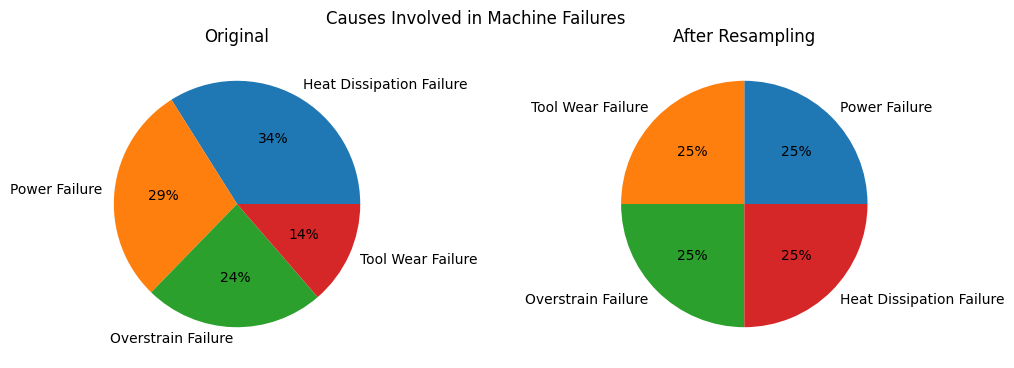

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify failures in the resampled DataFrame
failure_indices_resampled = df_resampled[df_resampled['failure_type'] != 'No Failure'].index
df_res_fail = df_resampled.loc[failure_indices_resampled]

# Calculate failure type percentages in the resampled DataFrame
failure_counts_resampled = df_res_fail['failure_type'].value_counts()
fail_res_percentage = 100 * failure_counts_resampled / df_res_fail.shape[0]

# Calculate percentage increment of observations after oversampling
percentage_increment = round((df_resampled.shape[0] - df.shape[0]) * 100 / df.shape[0], 2)

# Calculate percentage of failures in the resampled DataFrame
smote_resampled_failures_percentage = round(df_res_fail.shape[0] * 100 / df_resampled.shape[0], 2)

# Print results
print('Percentage increment of observations after oversampling:', percentage_increment)
print('SMOTE Resampled Failures percentage:', smote_resampled_failures_percentage)

# Create pie plots for failure causes
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
fig.suptitle('Causes Involved in Machine Failures')

# Original failures percentage
axs[0].pie(
    x=df_fail_percentage,
    labels=df_fail_percentage.index,
    colors=sns.color_palette('tab10')[0:4],
    autopct='%.0f%%'
)
axs[0].title.set_text('Original')

# Resampled failures percentage
axs[1].pie(
    x=fail_res_percentage,
    labels=fail_res_percentage.index,
    colors=sns.color_palette('tab10')[0:4],
    autopct='%.0f%%'
)
axs[1].title.set_text('After Resampling')

# Show plots
plt.show()

## Feature Scaling and Encoding

Scaling data is a difficult process as you have to choose the proper scaler to use 
- Use MinMaxScaler as your default
- Use RobustScaler if you have outliers and can handle a larger range
- Use StandardScaler if you need normalized features
- Use Normalizer sparingly - it normalizes rows, not columns

In [21]:
num_features = [feature for feature in features if df[feature].dtype=='float64']

In [26]:
from sklearn.preprocessing import StandardScaler

# Create an instance of StandardScaler
scaler = StandardScaler()

# Define dictionaries for encoding categorical variables
type_encoding = {'L': 0, 'M': 1, 'H': 2}
cause_encoding = {
    'No Failure': 0,
    'Power Failure': 1,
    'Overstrain Failure': 2,
    'Heat Dissipation Failure': 3,
    'Tool Wear Failure': 4
}
# Create a copy of the DataFrame to avoid modifying the original
df_preprocessed = df_resampled.copy()

# Encoding categorical variables without using inplace
df_preprocessed['type'] = df_preprocessed['type'].replace(to_replace=type_encoding)
df_preprocessed['failure_type'] = df_preprocessed['failure_type'].replace(to_replace=cause_encoding)

# Scaling numeric features
df_preprocessed[num_features] = scaler.fit_transform(df_preprocessed[num_features])

/var/folders/bq/m6w531zj0x1d5w35rqn1s5fh0000gn/T/ipykernel_40757/2809487511.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_preprocessed['type'] = df_preprocessed['type'].replace(to_replace=type_encoding)
/var/folders/bq/m6w531zj0x1d5w35rqn1s5fh0000gn/T/ipykernel_40757/2809487511.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_preprocessed['failure_type'] = df_preprocessed['failure_type'].replace(to_replace=cause_encoding)


In [27]:
from sklearn.decomposition import PCA

# Create PCA instance with the number of components equal to the number of features
pca = PCA(n_components=len(num_features))

# Fit PCA and transform the data, creating a DataFrame for the principal components
X_pca = pd.DataFrame(
    data=pca.fit_transform(df_preprocessed[num_features]),
    columns=[f'PC{i+1}' for i in range(len(num_features))]
)

# Calculate the explained variance ratio as a percentage
var_exp = pd.Series(
    data=100 * pca.explained_variance_ratio_,
    index=[f'PC{i+1}' for i in range(len(num_features))]
)

# Print the explained variance ratio per component
print('Explained variance ratio per component:')
print(round(var_exp, 2), sep='\n')

# Print the sum of the explained variance ratio for the first three components
explained_variance_three_components = round(var_exp.values[:3].sum(), 2)
print(f'Explained variance ratio with 3 components: {explained_variance_three_components}')

Explained variance ratio per component:
PC1    37.76
PC2    36.73
PC3    19.84
PC4     3.08
PC5     2.58
dtype: float64
Explained variance ratio with 3 components: 94.34


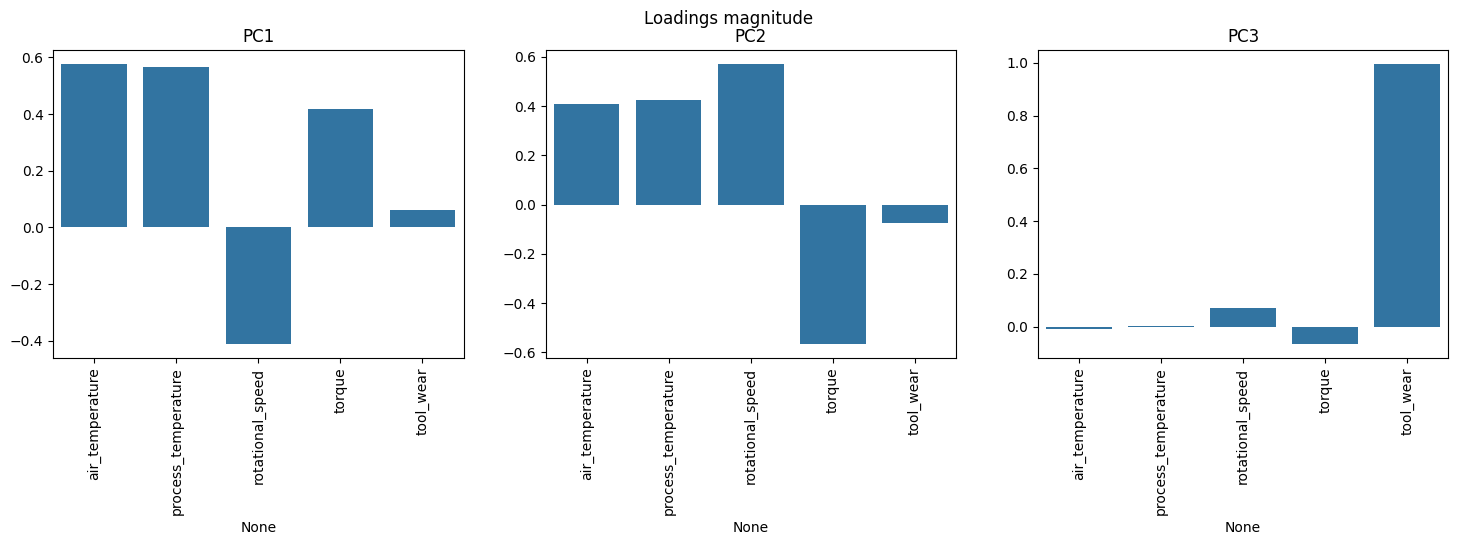

In [46]:
# PCA for Data visualization
pca3 = PCA(n_components=3)
X_pca3 = pd.DataFrame(
    data=pca3.fit_transform(df_preprocessed[num_features]),
      columns=['PC1','PC2','PC3'])

fig, axs = plt.subplots(ncols=3, figsize=(18,4))
fig.suptitle('Loadings magnitude')

pca_loadings = pd.DataFrame(data=pca3.components_, columns=num_features)
for j in range(3):
    ax = axs[j]
    sns.barplot(ax=ax, x=pca_loadings.columns, y=pca_loadings.values[j])
    ax.tick_params(axis='x', rotation=90)
    ax.title.set_text('PC'+str(j+1))
plt.show()

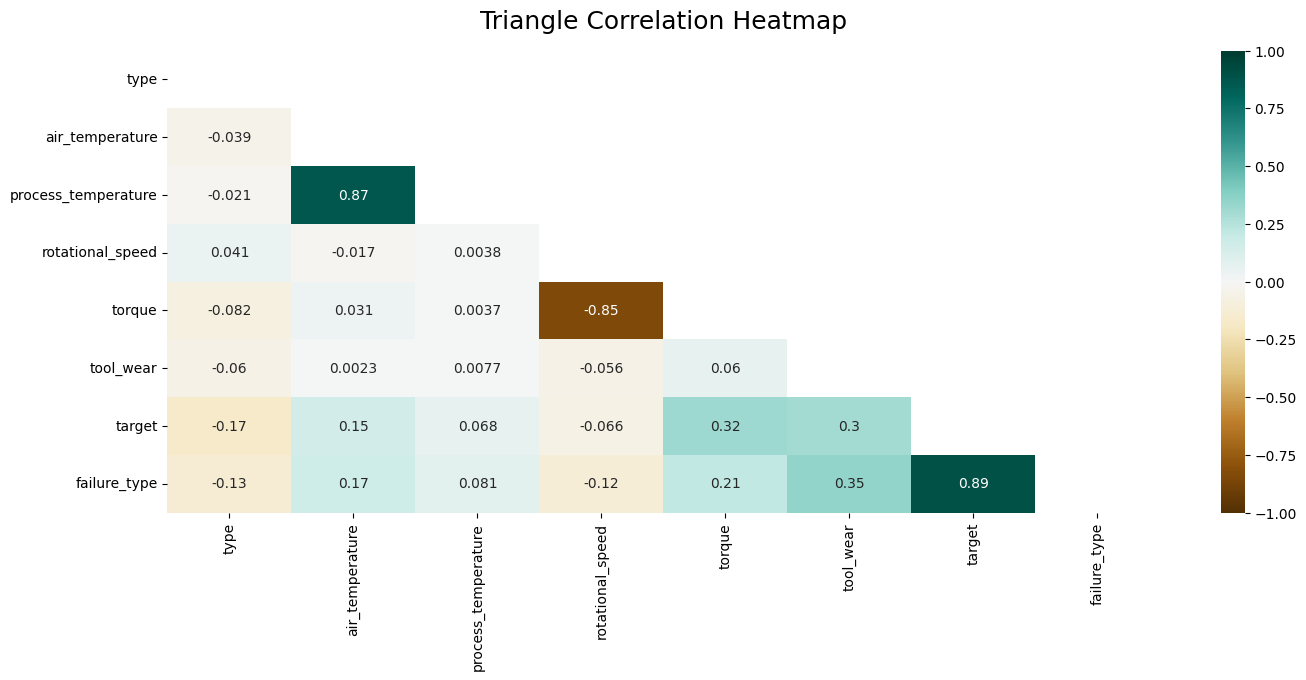

In [50]:
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df_preprocessed.corr(), dtype=np.bool))
heatmap = sns.heatmap(df_preprocessed.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);